# Try models

In [177]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score

In [180]:


def split(df):
    trn_len = int(np.floor(len(df) * 0.9))
    valid_len = len(df) - trn_len
    df['type'] = 0  #0 for train 1 for valid
    indexs = df.index
    df = df.reset_index()
    df.loc[trn_len:, 'type'] =  1
    return df
data_raw = pd.read_csv('./data/air_visit_data.csv')
test = pd.read_csv('./data/sample_submission.csv')
test_data = utils.tes2trn(test)
test_stores = test_data.air_store_id.unique()
data = data_raw[data_raw.air_store_id.isin(test_stores)]
tag_data = data.groupby('air_store_id').apply(split)
t = tag_data.set_index('index')
train_set = t[t.type == 0]
valid_set = t[t.type == 1]
train_set = train_set.reset_index().drop(['index', 'type'], axis=1)
valid_set = valid_set.reset_index().drop(['index', 'type'], axis=1)

len(train_set), len(train_set.air_store_id.unique()), len(valid_set), len(valid_set.air_store_id.unique())

(225049, 821, 25419, 821)

In [129]:
feas = utils.data2fea_v2(train_set, data_dir, drop_vars=drop_vars)
tidy_data = feas['tidy_data']

In [161]:
data_dir

'./data'

In [181]:
X_train, y_train, y_train_orig, max_log_y, g_y_trn, contin_map_fit, cat_map_fit = utils.get_data(train_set)
X_valid, y_valid, y_valid_orig, _, g_y_valid = utils.get_data(valid_set, contin_map_fit=contin_map_fit, cat_map_fit=cat_map_fit)

,air_store_id,visit_date,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std,genre_name,area_name,hpb_genre_name,...,stores_in_hpb_loc,stores_in_area_name,stores_in_hpb_area_name,Date,holiday_flg,af_holiday_flg,be_holiday_flg,dur_time_holiday_flg,dur_holiday_flg,dur_prog_holiday_flg
0,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2016-07-01,0,57,-17,0,0,0.0
1,air_00a91d42b08b08d9,2016-07-02,9,35.0,35.0,35.0,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2016-07-02,0,58,-16,0,0,0.0
2,air_00a91d42b08b08d9,2016-07-04,20,35.0,9.0,22.0,18.384776,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2016-07-04,0,60,-14,0,0,0.0
3,air_00a91d42b08b08d9,2016-07-05,25,35.0,9.0,20.0,13.051181,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2016-07-05,0,61,-13,0,0,0.0
4,air_00a91d42b08b08d9,2016-07-06,29,35.0,9.0,22.5,10.812801,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2016-07-06,0,62,-12,0,0,0.0


,air_store_id,visit_date,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std,genre_name,area_name,hpb_genre_name,...,prop_seasonal,prop_seasonal_lower,prop_seasonal_upper,prop_seasonalities,prop_seasonalities_lower,prop_seasonalities_upper,prop_weekly,prop_weekly_lower,prop_weekly_upper,prop_yhat
0,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.802315,0.802315,0.802315,0.802315,0.802315,0.802315,0.802315,0.802315,0.802315,32.349058
1,air_00a91d42b08b08d9,2016-07-02,9,35.0,35.0,35.0,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,10.118049
2,air_00a91d42b08b08d9,2016-07-04,20,35.0,9.0,22.0,18.384776,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,18.209553
3,air_00a91d42b08b08d9,2016-07-05,25,35.0,9.0,20.0,13.051181,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,19.822418
4,air_00a91d42b08b08d9,2016-07-06,29,35.0,9.0,22.5,10.812801,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,24.567333


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:651: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/

,air_store_id,visit_date,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std,genre_name,area_name,hpb_genre_name,...,stores_in_hpb_loc,stores_in_area_name,stores_in_hpb_area_name,Date,holiday_flg,af_holiday_flg,be_holiday_flg,dur_time_holiday_flg,dur_holiday_flg,dur_prog_holiday_flg
0,air_00a91d42b08b08d9,2017-03-25,7,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2017-03-25,0,5,-35,0,0,0.0
1,air_00a91d42b08b08d9,2017-03-27,43,7.0,7.0,7.0,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2017-03-27,0,7,-33,0,0,0.0
2,air_00a91d42b08b08d9,2017-03-28,30,43.0,7.0,25.0,25.455844,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2017-03-28,0,8,-32,0,0,0.0
3,air_00a91d42b08b08d9,2017-03-29,52,43.0,7.0,30.0,18.230012,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2017-03-29,0,9,-31,0,0,0.0
4,air_00a91d42b08b08d9,2017-03-30,33,52.0,7.0,36.5,19.544820,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,257.0,10.0,NaN,2017-03-30,0,10,-30,0,0,0.0


,air_store_id,visit_date,visitors,rolling_60d_max,rolling_60d_min,rolling_60d_median,rolling_60d_std,genre_name,area_name,hpb_genre_name,...,prop_seasonal,prop_seasonal_lower,prop_seasonal_upper,prop_seasonalities,prop_seasonalities_lower,prop_seasonalities_upper,prop_weekly,prop_weekly_lower,prop_weekly_upper,prop_yhat
0,air_00a91d42b08b08d9,2017-03-25,7,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,-0.360311,12.231771
1,air_00a91d42b08b08d9,2017-03-27,43,7.0,7.0,7.0,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,0.226591,22.039769
2,air_00a91d42b08b08d9,2017-03-28,30,43.0,7.0,25.0,25.455844,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,0.311096,24.006122
3,air_00a91d42b08b08d9,2017-03-29,52,43.0,7.0,30.0,18.230012,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,0.525338,29.770147
4,air_00a91d42b08b08d9,2017-03-30,33,52.0,7.0,36.5,19.544820,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,NaN,...,0.598344,0.598344,0.598344,0.598344,0.598344,0.598344,0.598344,0.598344,0.598344,32.055458


ValueError: too many values to unpack (expected 5)

In [182]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X, y_train.ravel(), feature_name=all_vars, categorical_feature=cat_vars, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid.ravel(), reference=lgb_train, free_raw_data=False)

In [183]:
# specify your configurations as a dict
params = {
    'task': 'train',
#     'boosting_type': 'dart',
    'objective': 'regression',
#     'metric': {'mse'},
    'num_leaves': 50,
    'learning_rate': 0.08,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_bin': 15,
    'max_depth': 40
}
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=(lgb_train, lgb_eval),
                feval=rmsle_wo_log,
                evals_result=evals_result,
                ) # early_stopping_rounds=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1032: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['air_store_id', 'area_name', 'genre_name', 'hpb_genre_name', 'visit_date_year']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Library/Frameworks/Python.framework/

[1]	training's rmsle: 0.76659	valid_1's rmsle: 0.756894
[2]	training's rmsle: 0.731067	valid_1's rmsle: 0.72226
[3]	training's rmsle: 0.699659	valid_1's rmsle: 0.693145
[4]	training's rmsle: 0.671927	valid_1's rmsle: 0.668518
[5]	training's rmsle: 0.647685	valid_1's rmsle: 0.647599
[6]	training's rmsle: 0.626296	valid_1's rmsle: 0.629574
[7]	training's rmsle: 0.607564	valid_1's rmsle: 0.61294
[8]	training's rmsle: 0.591437	valid_1's rmsle: 0.601141
[9]	training's rmsle: 0.577132	valid_1's rmsle: 0.590887
[10]	training's rmsle: 0.564597	valid_1's rmsle: 0.583534
[11]	training's rmsle: 0.553713	valid_1's rmsle: 0.577687
[12]	training's rmsle: 0.544364	valid_1's rmsle: 0.573372
[13]	training's rmsle: 0.536305	valid_1's rmsle: 0.567933
[14]	training's rmsle: 0.529318	valid_1's rmsle: 0.565492
[15]	training's rmsle: 0.523308	valid_1's rmsle: 0.563883
[16]	training's rmsle: 0.518198	valid_1's rmsle: 0.561376
[17]	training's rmsle: 0.513738	valid_1's rmsle: 0.560939
[18]	training's rmsle: 0.5

[144]	training's rmsle: 0.48332	valid_1's rmsle: 0.574991
[145]	training's rmsle: 0.483313	valid_1's rmsle: 0.574976
[146]	training's rmsle: 0.4833	valid_1's rmsle: 0.574967
[147]	training's rmsle: 0.483286	valid_1's rmsle: 0.574765
[148]	training's rmsle: 0.483274	valid_1's rmsle: 0.574712
[149]	training's rmsle: 0.483258	valid_1's rmsle: 0.574681
[150]	training's rmsle: 0.483243	valid_1's rmsle: 0.574702
[151]	training's rmsle: 0.48323	valid_1's rmsle: 0.574667
[152]	training's rmsle: 0.483216	valid_1's rmsle: 0.574573
[153]	training's rmsle: 0.483202	valid_1's rmsle: 0.574553
[154]	training's rmsle: 0.483189	valid_1's rmsle: 0.574519
[155]	training's rmsle: 0.483176	valid_1's rmsle: 0.574543
[156]	training's rmsle: 0.483167	valid_1's rmsle: 0.57454
[157]	training's rmsle: 0.483149	valid_1's rmsle: 0.57456
[158]	training's rmsle: 0.483139	valid_1's rmsle: 0.574571
[159]	training's rmsle: 0.483127	valid_1's rmsle: 0.574592
[160]	training's rmsle: 0.483119	valid_1's rmsle: 0.574633
[16

In [192]:
# ax = lgb.plot_metric(evals_result, metric='rmsle')
# ax = lgb.plot_importance(gbm, max_num_features=10)


In [191]:
def verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y):
    from sklearn import linear_model

    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    pred_valid = reg.predict(X_valid)
    pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
    # pred_valid_orig = pred_valid
    valid_loss = rmsle(pred_valid_orig, y_valid_orig)
    pred_trn = reg.predict(X_train)
    pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
    # pred_trn_orig = pred_trn
    trn_loss = rmsle(pred_trn_orig, y_train_orig)
#     plt.figure(1)
#     plt.plot(pred_valid_orig[:100], c='b')
#     plt.plot(y_valid_orig[:100], c='r')
    print('Linear Model train loss: {}, valid loss: {}'.format( trn_loss, valid_loss))
    return reg

reg = verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y)



base_valid= rmsle(g_y_trn.values, y_train_orig.ravel())
base_trn= rmsle(g_y_valid.values, y_valid_orig.ravel())

print('Base line train loss {}, valid loss {}'.format(base_trn, base_valid))

# split_point = X.shape[0] - y_valid_orig.ravel().shape[0]
# base_line = rmsle(tidy_data['prop_yhat'].values[split_point:].ravel(), y_valid_orig.ravel())

pred_valid = gbm.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig.ravel())
pred_trn = gbm.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig.ravel())
print('LightBGM train loss: {}, valid loss: {}'.format(trn_loss, valid_loss))

# plt.figure(2)
# plt.plot(pred_valid_orig[:100], c='b')
# plt.plot(y_valid_orig[:100], c='r')

Linear Model train loss: 0.4890664207426338, valid loss: 0.5539520227319201
Base line train loss 0.48569097354010166, valid loss 0.48959534832409946
LightBGM train loss: 0.48264891988588793, valid loss: 0.5411426703101263


# Submit


In [142]:
data_dir = r'./data'
test = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(test)
trn_like_test = trn_like_test.assign(visitors = np.round(np.random.rand(len(trn_like_test)) * 100))

X_test, y_test, y_test_orig, _ = get_data(trn_like_test)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF/utils.py:650: RuntimeWarning: invalid value encountered in log1p
  max_log_y = np.max(np.log1p(y_orig))
/Users/kevindu/Documents/workspace/ml_utils/

In [143]:

pred_reg = utils.log_max_inv(reg.predict(X), max_log_y)
pred_gbm = utils.log_max_inv(gbm.predict(X), max_log_y)

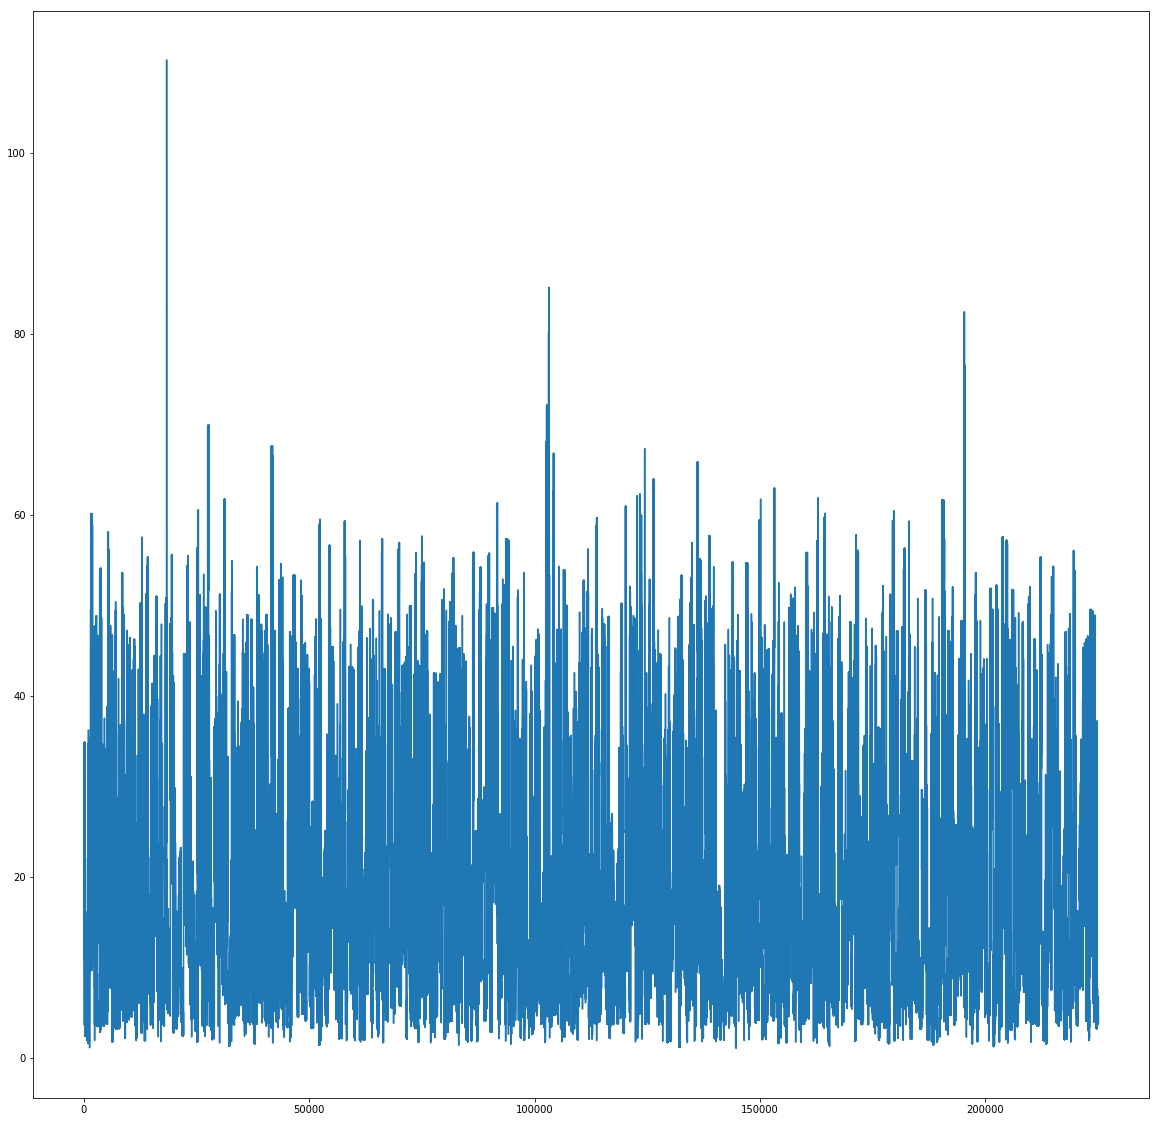

In [144]:
# plt.plot(pred_reg)
plt.plot(pred_gbm)

In [85]:
test.visitors = pred_gbm
test.to_csv('result/gbm.csv', index=False)
test.visitors = pred_reg
test.loc[test.visitors<0, "visitors"] = 0
test.to_csv('result/reg.csv', index=False)